![birdclef](images/header.png)

# BirdCLEF 2021 – Audio Classification

## Author: [Jeremy Pagirsky](mailto:jeremy.pagirsky@gmail.com)

## Background

The Cornell Lab of Ornithology estimates about 10,000 bird species throughout the world. In addition to their relatively high position in the food chain, this makes birds great informants of air quality and biodiversity in various ecosystems. The identification of birds in their habitats is especially helpful for researchers and ornithological experts to implement conservation efforts.

Machine learning, particularly deep learning, has been helpful in bolstering acoustic data collection. Models to date, however, have presented inconsistencies in precision and recall abilities.

Source: [BirdCLEF 2021 Kaggle Competition](https://www.kaggle.com/c/birdclef-2021)

## Objective

This project seeks to implement deep learning techniques to identify bird species captured in audio recordings. Multiple model architectures are constructed and compared against each other for accuracy, precision, recall, and F1 scores.

## Data

The data was obtained from the [BirdCLEF 2021](https://www.kaggle.com/c/birdclef-2021) Kaggle competition. The dataset contains over 62,000 audio recordings of approximately 400 species of birds.

## Imports

In [1]:
#core operations
import numpy as np
import pandas as pd
import os
from tqdm import tqdm #progress bar

#audio and image processing libraries
import soundfile as sf
import librosa
import librosa.display as display
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
import IPython.display as ipd

#sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#deep learning modules
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import (Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPool1D, MaxPool2D,
BatchNormalization, TimeDistributed, LayerNormalization, Bidirectional, Activation)
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1, l2

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

#warnings
import warnings
warnings.filterwarnings("ignore")

## Functions, Classes, and Variables

In [2]:
class coefs:
    """
    Class of coefficients defined with values for future operations.
    """
    # Generate Subset
    rat_id = 4 # rating subset limiter 
    recs = 200 # each specie must have X recodings
    max_files = 10000 # general last limit for rows
    thresh = 0.25 # label probability selection threshold
    submission = True # For Submission Only (Less Inference Output)
    
    # Global vars
    seed = 1234
    sr = 16000        # librosa sample rate input
    sl = 5 # seconds   
    sshape = (48,128) # height x width
    fmin = 500      # spectrum min frequency
    fmax = 12500    # spectrum max frequency
    n_epoch = 100   # training epochs
    cutoff = 15     # 3 sample spectrogram (training) overwritten for inference

path_switch = False

Source code for above class: [DrCapa](https://www.kaggle.com/drcapa/birdclef-2021-starter)

In [3]:
def plot_audio_file(data, samplerate):
    """
    Displays wave form of audio file.
    """
    sr = samplerate
    fig = plt.figure(figsize=(8, 4))
    x = range(len(data))
    y = data
    plt.plot(x, y)
    plt.plot(x, y, color='blue')
    plt.legend(loc='upper center')
    plt.grid()
    
def plot_signals(signals):
    """
    Plots signals for each bird class.
    """
    fig, axes = plt.subplots(nrows=7, ncols=4, sharex=False,
                             sharey=True, figsize=(20,15))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(7):
        for y in range(4):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
    
def get_spectrograms(filepath, primary_label, output_dir):
    """
    Inputs path to audio file. Performs short-time fourier transformation (STFT) and
    outputs mel spectrogram, a visual representation of the audio's physical properties
    (i.e., frequency, amplitude) over time.
    """
    # Open the file with librosa (limited to the first 15 seconds)
    sig, rate = librosa.load(filepath, sr=coefs.sr, offset=None, duration=15, mono=True)
    
    # Split signal into five second chunks
    sig_splits = []
    for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
        split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

        # End of signal?
        if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
            break
        
        sig_splits.append(split)
        
    # Extract mel spectrograms for each audio chunk
    s_cnt = 0
    saved_samples = []
    for chunk in sig_splits:
        
        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                                  sr=16000, 
                                                  n_fft=1024, 
                                                  hop_length=hop_length, 
                                                  n_mels=SPEC_SHAPE[0], 
                                                  fmin=FMIN, 
                                                  fmax=FMAX)
    
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 
        
        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
        
        # Save as image file
        save_dir = os.path.join(output_dir, primary_label)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + 
                                 '_' + str(s_cnt) + '.png')
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(save_path)
        
        saved_samples.append(save_path)
        s_cnt += 1
        
    return saved_samples

def fft_calc(y, rate):
    """
    Performs fast fourier transform, converting time series data into frequency domain.
    """
    n = len(y)
    freq = np.fft.rfftfreq(n, d=(1/rate))
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

def plot_fft(fft):
    """
    Plots periodograms (frequency domain) of signals passed through a fast fourier transformation.
    """
    fig, axes = plt.subplots(nrows=5, ncols=5, sharex=False,
                             sharey=True, figsize=(20,12))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(5):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def envelope(signal, rate, threshold):
    """
    Inputs audio data in the form of a numpy array. Converts to pandas series
    to find the rolling average and apply the absolute value to the signal at all points.
    
    Additionally takes in the sample rate and threshold (amplitude). Data below the threshold
    will be filtered out. This is useful for filtering out environmental noise from recordings. 
    """
    mask = []
    signal = pd.Series(signal).apply(np.abs) # Convert to series to find rolling average and apply absolute value to the signal at all points. 
    signal_mean = signal.rolling(window = int(rate/10), min_periods = 1, center = True).mean() # Take the rolling average of the series within our specified window.
    
    for mean in signal_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return np.array(mask)

def plot_spectrogram(data, samplerate):
    """ Plot spectrogram with mel scaling in time domain. """
    sr = 16000
    spectrogram = librosa.feature.melspectrogram(data, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    
def make_bar_chart(df, column):
    """
    Function that inputs column name and outputs the frequency of its classes as a bar chart.
    """
    val_cts = df[column].value_counts()

    # Make bar chart
    fig = go.Figure(data=[go.Bar(y=val_cts.values, x=val_cts.index)],
                    layout=go.Layout(margin=go.layout.Margin(l=0, r=0, b=70, t=50)))

    # Show chart
    fig.update_layout(title=f"Number of samples for {column}")
    fig.show()
    
def get_map(df):
    
    """
    Takes in dataframe and outputs map of audio recording locations. Dataframe is either original 
    (train_metadata.csv) or a subset. Column names are constant. Displays below information with hover.
    """
    
    fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", hover_name="common_name", 
                        hover_data=["primary_label", "scientific_name", "date"],
                        color_discrete_sequence=["palevioletred"], zoom=1, width=1050, height=650)
    fig.update_layout(
        mapbox_style="white-bg",
        mapbox_layers=[
            {
                "below": 'traces',
                "sourcetype": "raster",
                "sourceattribution": "United States Geological Survey",
                "source": [
                    "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
                ]
            }
        ])
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()
    
def visualize_training_results(results):
    """
    Displays training loss and accuracy metrics across epochs.
    """
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Directories and Datasets

In [4]:
#create main directory variable
MAIN_DIR = '/kaggle/input/birdclef-2021/'
os.listdir(MAIN_DIR)

['train_soundscape_labels.csv',
 'sample_submission.csv',
 'train_soundscapes',
 'train_short_audio',
 'test.csv',
 'train_metadata.csv',
 'test_soundscapes']

In [5]:
train_labels = pd.read_csv(MAIN_DIR+'train_soundscape_labels.csv') #data on 10 min. recordings
train_meta = pd.read_csv(MAIN_DIR+'train_metadata.csv') #metadata of short recordings
test_data = pd.read_csv(MAIN_DIR+'test.csv') #test data
samp_subm = pd.read_csv(MAIN_DIR+'sample_submission.csv') #reference for submission

In [6]:
print('Number train label samples:', len(train_labels))
print('Number train meta samples:', len(train_meta))
print('Number train short folder:', len(os.listdir(MAIN_DIR+'train_short_audio')))
print('Number train audios:', len(os.listdir(MAIN_DIR+'train_soundscapes')))
print('Number test samples:', len(test_data))

Number train label samples: 2400
Number train meta samples: 62874
Number train short folder: 397
Number train audios: 20
Number test samples: 3


In [7]:
train_meta.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981


In [8]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62874 entries, 0 to 62873
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     62874 non-null  object 
 1   secondary_labels  62874 non-null  object 
 2   type              62874 non-null  object 
 3   latitude          62874 non-null  float64
 4   longitude         62874 non-null  float64
 5   scientific_name   62874 non-null  object 
 6   common_name       62874 non-null  object 
 7   author            62874 non-null  object 
 8   date              62874 non-null  object 
 9   filename          62874 non-null  object 
 10  license           62874 non-null  object 
 11  rating            62874 non-null  float64
 12  time              62874 non-null  object 
 13  url               62874 non-null  object 
dtypes: float64(3), object(11)
memory usage: 6.7+ MB


In [9]:
#check for duplicate audio recordings
train_meta['filename'].duplicated().sum()

0

## Distribution of Data

In [10]:
make_bar_chart(train_meta, 'primary_label')

In order to mitigate model training issues related to class imbalance, the below code filters out data based on two criteria:

- **Quantity of recordings per spcies:** A minimum of 200 recordings per species.
- **Quality of recording:** Ratings of 4 and above.

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x = train_meta['rating'], palette="hls", order = train_meta['rating'])

plt.title("Sound quality rating", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

Source: [Ayush Thakur](https://www.kaggle.com/ayuraj/birdclef-quick-eda-with-w-b)

In [13]:
# Load metadata file
train = pd.read_csv('../input/birdclef-2021/train_metadata.csv',)

# Limit the number of training samples and classes
# First, only use high quality samples
train = train.query('rating>=4')

# Second, assume that birds with the most training samples are also the most common
# A species needs at least 200 recordings with a rating above 4 to be considered common
birds_count = {}
for bird_species, count in zip(train.primary_label.unique(), 
                               train.groupby('primary_label')['primary_label'].count().values):
    birds_count[bird_species] = count
most_represented_birds = [key for key,value in birds_count.items() if value >= 200] 

TRAIN = train.query('primary_label in @most_represented_birds')
LABELS = sorted(TRAIN.primary_label.unique())

# Let's see how many species and samples we have left
print('NUMBER OF SPECIES IN TRAIN DATA:', len(LABELS))
print('NUMBER OF SAMPLES IN TRAIN DATA:', len(TRAIN))
print('LABELS:', most_represented_birds)

NUMBER OF SPECIES IN TRAIN DATA: 27
NUMBER OF SAMPLES IN TRAIN DATA: 8548
LABELS: ['amerob', 'barswa', 'bewwre', 'blujay', 'bncfly', 'carwre', 'compau', 'comrav', 'comyel', 'eursta', 'gbwwre1', 'grekis', 'houspa', 'houwre', 'mallar3', 'norcar', 'normoc', 'redcro', 'rewbla', 'roahaw', 'rubpep1', 'rucspa1', 'sonspa', 'spotow', 'wbwwre1', 'wesmea', 'yeofly1']


Source for above code: [Francois Lemarchand](https://www.kaggle.com/frlemarchand/bird-song-classification-using-an-efficientnet)

In [14]:
TRAIN.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
1466,amerob,[],['call'],43.0770,-96.1700,Turdus migratorius,American Robin,Jonathon Jongsma,2012-06-23,XC107523.ogg,Creative Commons Attribution-ShareAlike 3.0,4.0,21:00,https://www.xeno-canto.org/107523
1467,amerob,[],['flight call'],44.9420,-93.2590,Turdus migratorius,American Robin,Jonathon Jongsma,2012-10-30,XC112597.ogg,Creative Commons Attribution-ShareAlike 3.0,4.0,14:00,https://www.xeno-canto.org/112597
1471,amerob,[],['song'],43.0802,-96.1643,Turdus migratorius,American Robin,Jonathon Jongsma,2013-04-03,XC128490.ogg,Creative Commons Attribution-ShareAlike 3.0,5.0,06:22,https://www.xeno-canto.org/128490
1473,amerob,"['mallar3', 'comyel']",['song'],35.0307,-120.6205,Turdus migratorius,American Robin,Thomas G. Graves,2013-04-14,XC129798.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.5,7:47,https://www.xeno-canto.org/129798
1477,amerob,"['norcar', 'rewbla', 'comgra', 'amecro', 'bluj...",['call'],43.0770,-96.1700,Turdus migratorius,American Robin,Jonathon Jongsma,2013-04-20,XC131093.ogg,Creative Commons Attribution-ShareAlike 3.0,4.5,06:38,https://www.xeno-canto.org/131093


In [15]:
row = 0
TRAIN.iloc[row]

primary_label                                            amerob
secondary_labels                                             []
type                                                   ['call']
latitude                                                 43.077
longitude                                                -96.17
scientific_name                              Turdus migratorius
common_name                                      American Robin
author                                         Jonathon Jongsma
date                                                 2012-06-23
filename                                           XC107523.ogg
license             Creative Commons Attribution-ShareAlike 3.0
rating                                                      4.0
time                                                      21:00
url                           https://www.xeno-canto.org/107523
Name: 1466, dtype: object

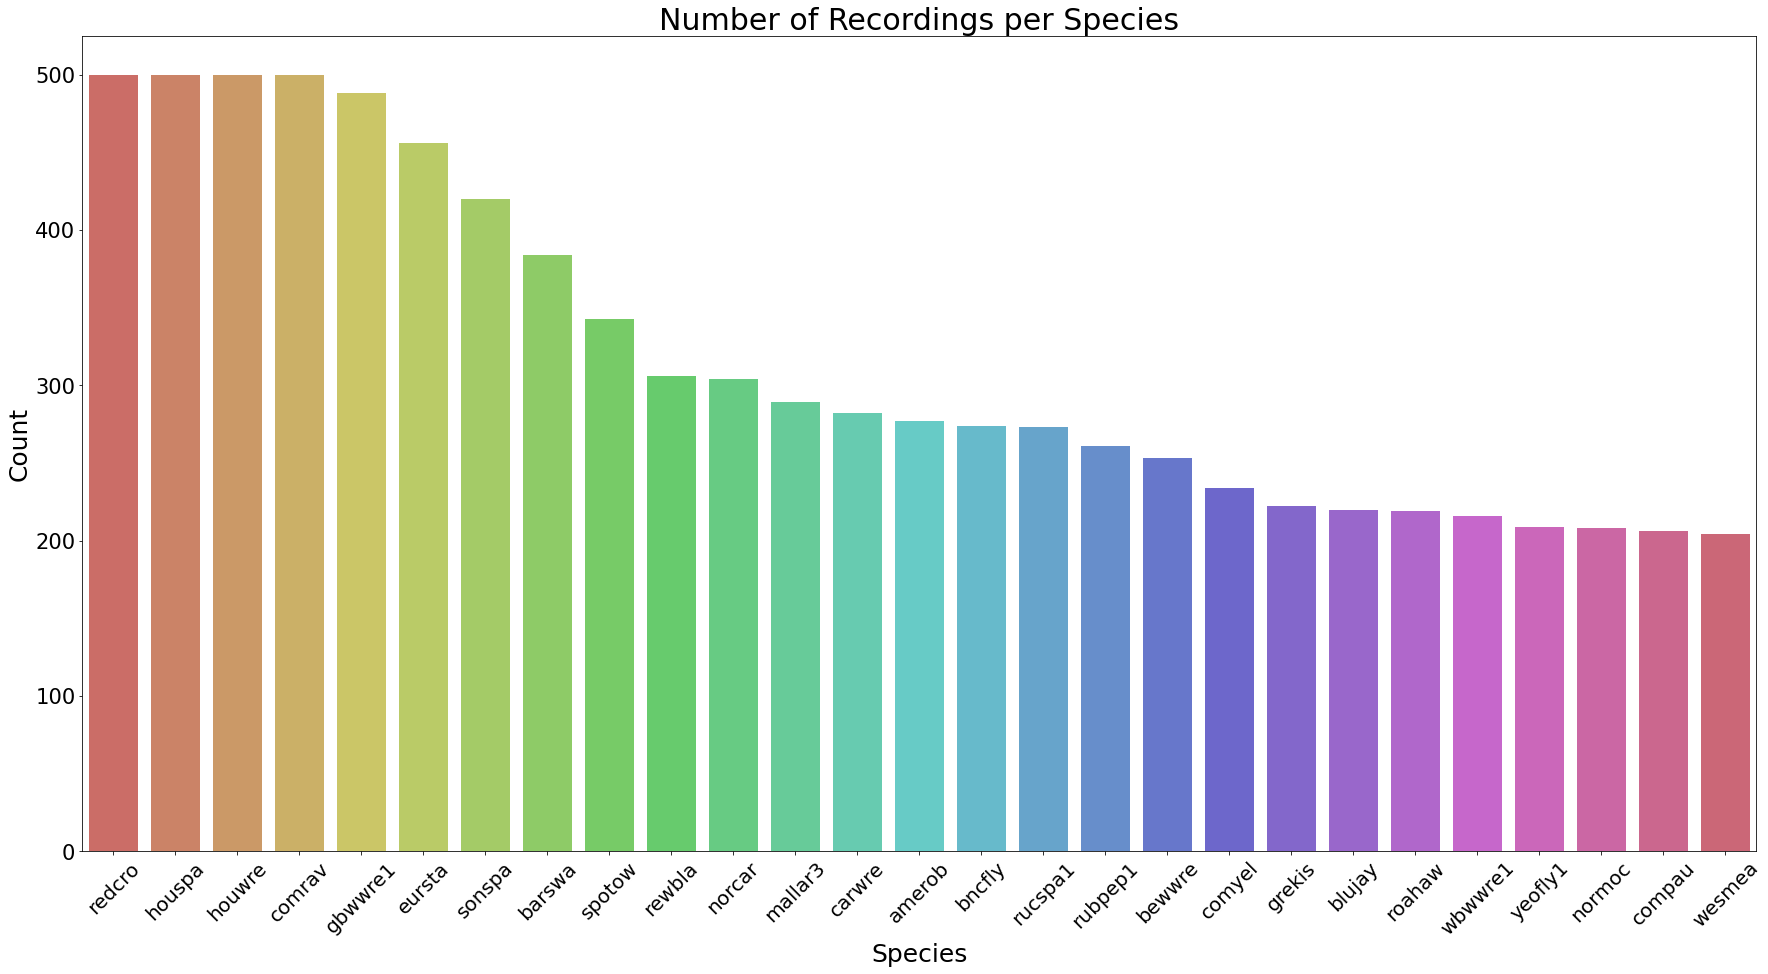

In [17]:
plt.figure(figsize=(30, 15))
sns.countplot(x=TRAIN['primary_label'],
              palette='hls',
              order=TRAIN['primary_label'].value_counts().index)

plt.title("Number of Recordings per Species", fontsize=30)
plt.xlabel("Species", fontsize=25)
plt.ylabel("Count", fontsize=25)
plt.yticks(fontsize=21)
plt.xticks(rotation=45, fontsize=20);

In [18]:
# bird species for testing
classes = list(TRAIN['primary_label'].unique())
classes

['amerob',
 'barswa',
 'bewwre',
 'blujay',
 'bncfly',
 'carwre',
 'compau',
 'comrav',
 'comyel',
 'eursta',
 'gbwwre1',
 'grekis',
 'houspa',
 'houwre',
 'mallar3',
 'norcar',
 'normoc',
 'redcro',
 'rewbla',
 'roahaw',
 'rubpep1',
 'rucspa1',
 'sonspa',
 'spotow',
 'wbwwre1',
 'wesmea',
 'yeofly1']

### Locations of recordings in subset

In [19]:
get_map(TRAIN)

## Representations of Audio Data

In [20]:
labels = TRAIN['primary_label']
len(labels)

8548

In [21]:
filenames = TRAIN['filename']
filenames

1466     XC107523.ogg
1467     XC112597.ogg
1471     XC128490.ogg
1473     XC129798.ogg
1477     XC131093.ogg
             ...     
62522     XC81740.ogg
62523     XC81741.ogg
62524     XC81742.ogg
62525     XC81743.ogg
62528      XC8867.ogg
Name: filename, Length: 8548, dtype: object

In [22]:
label = TRAIN.loc[1466, 'primary_label']
filename = TRAIN.loc[1466, 'filename']

# Check if the file is in the folder
filename in os.listdir(MAIN_DIR+'train_short_audio/'+label)

True

In [23]:
data, coefs.sr = sf.read(MAIN_DIR+'train_short_audio/'+label+'/'+filename)
print(f"Label: {label}")
print(f"File name: {filename}")
print(f"Sample rate: {coefs.sr}")

Label: amerob
File name: XC107523.ogg
Sample rate: 32000


Below are three representations of the above audio file: **./amerob/XC107523.ogg**

### Audio

A single .ogg file output by librosa. 

In [24]:
for c in classes:
    audio_file = TRAIN[TRAIN['primary_label'] == c].iloc[0,9]
    play = ipd.Audio(MAIN_DIR+'train_short_audio/'+c+'/'+audio_file)

print(audio_file)
play

XC114463.ogg


### Waveform

Samples of waveforms for each class. Below are their fast-fourier transformations, which compute the occurrence of frequencies in a given recording.

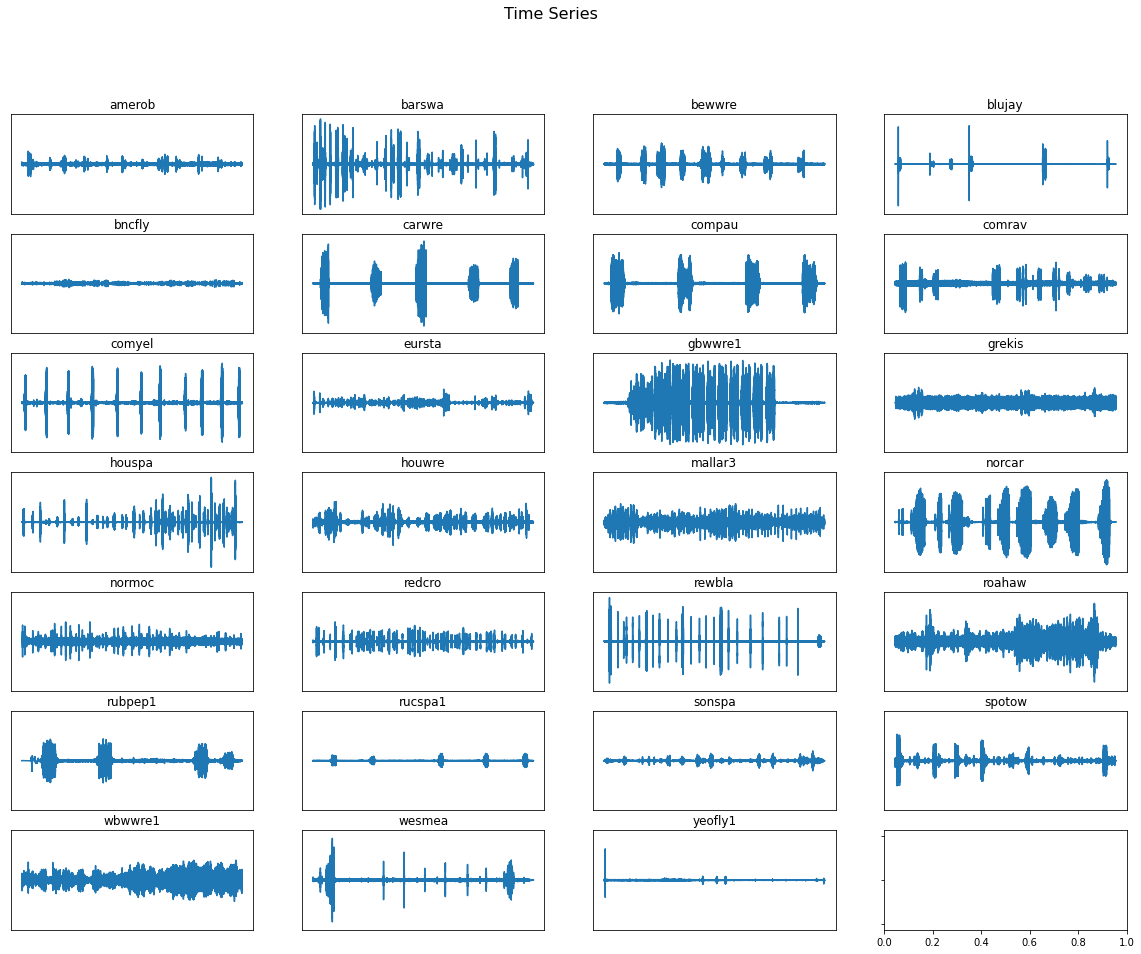

In [25]:
try:
    sig = {}
    fft = {}
    
    for c in classes:
        audio_file = TRAIN[TRAIN['primary_label'] == c].iloc[0,9]
        signal, rate = librosa.load(MAIN_DIR+'train_short_audio/'+c+'/'+audio_file, coefs.sr, mono=True)
        sig[c] = signal
        fft[c] = fft_calc(sig[c], 16000) #included fast fourier transform

    plot_signals(sig)

except IndexError:
    pass

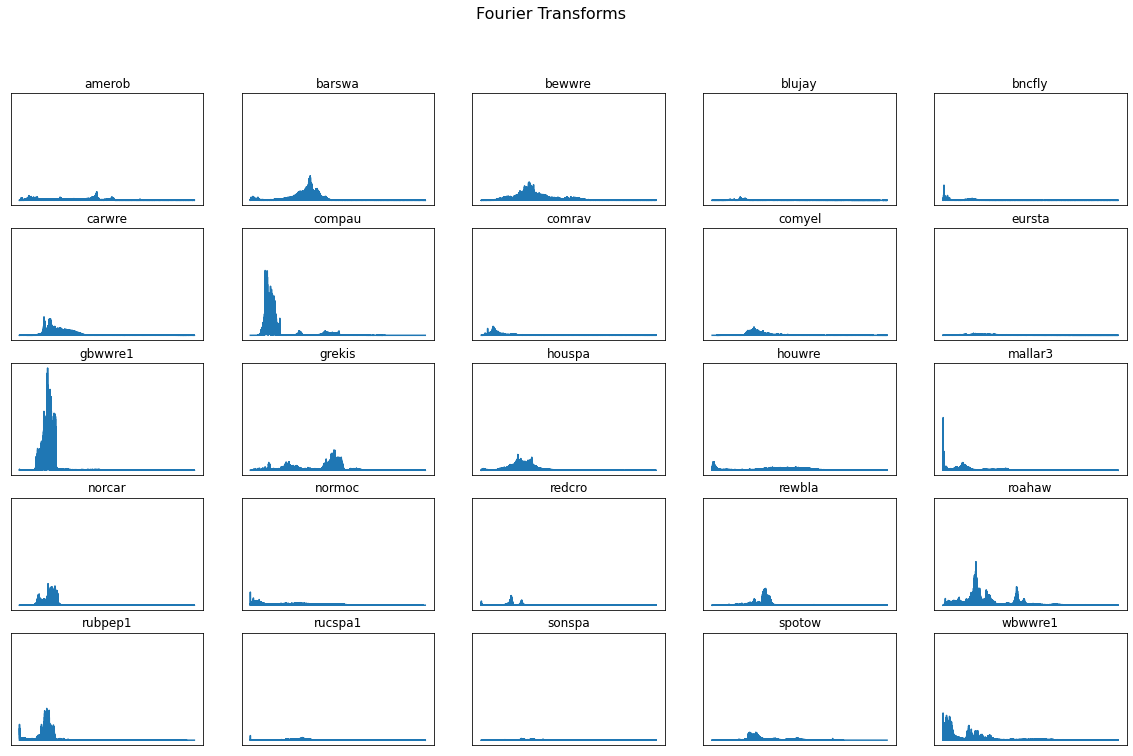

In [26]:
plot_fft(fft)

### Mel Spectrogram

A visual representation of the audio file as frequency over time. The brighter colors represent higher levels of amplitude.

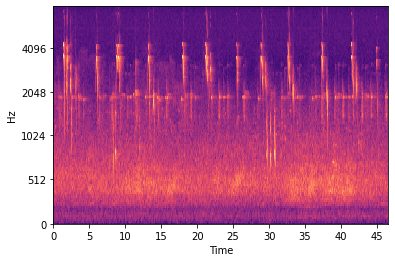

In [27]:
#sample rate = 16000
plot_spectrogram(data, 16000)

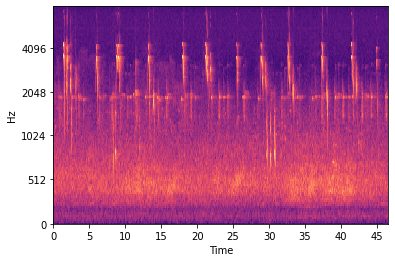

In [28]:
#sample rate = 32000
plot_spectrogram(data, 32000)

## Data Transformation and Generation

### Envelope

Utilizing the below function to remove any "dead space" of the audio files.

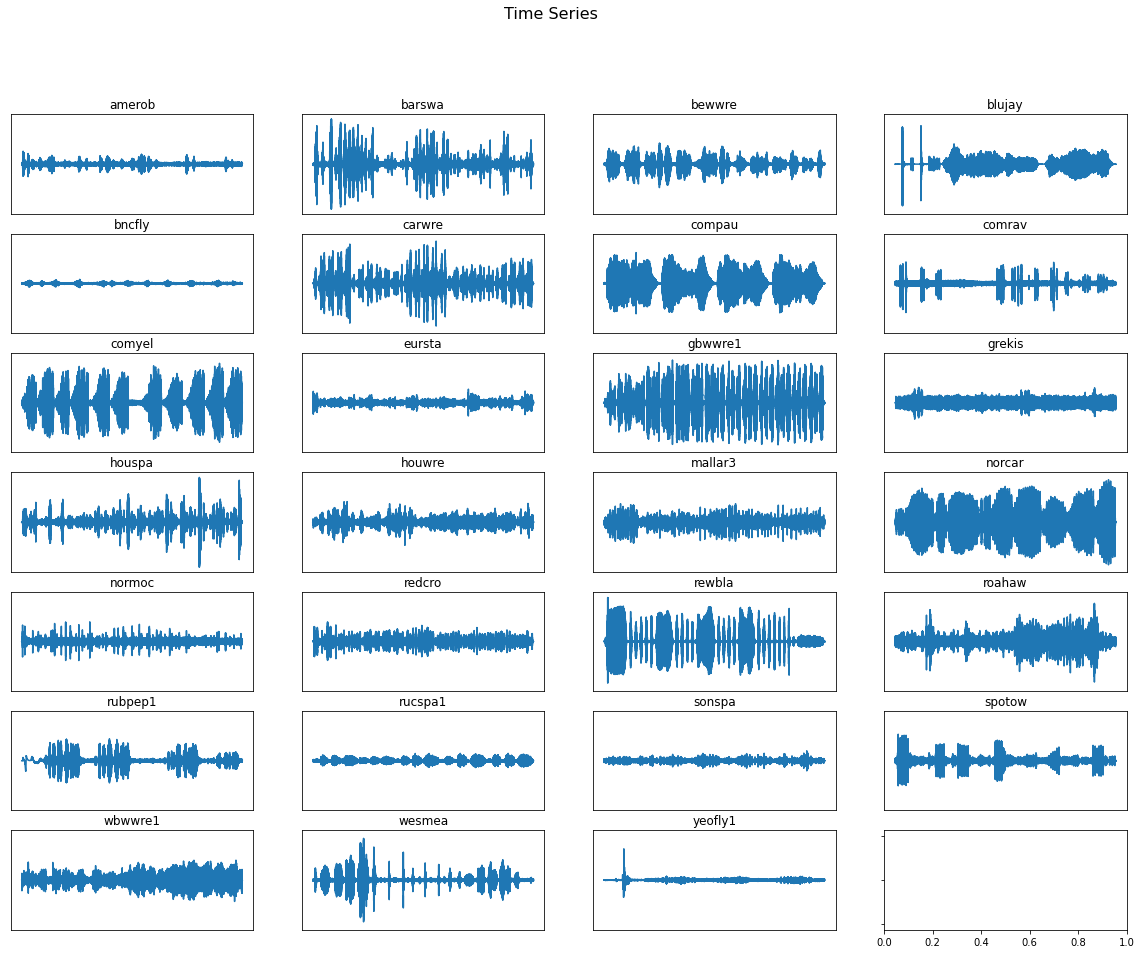

In [29]:
try:
    sig_new = {}
    fft_new = {}
    
    # Clean displayed audio from above.
    for c in classes:
        audio_file = TRAIN[TRAIN['primary_label'] == c].iloc[0,9]
        signal, rate = librosa.load(MAIN_DIR+'train_short_audio/'+c+'/'+audio_file, sr=coefs.sr, mono=True)
        mask = envelope(signal, rate, 0.009) #(array, sample_rate, dB threshold)
        signal = signal[mask]
        sig_new[c] = signal
        fft_new[c] = fft_calc(sig_new[c], 16000)

    plot_signals(sig_new)
    
except IndexError:
    pass

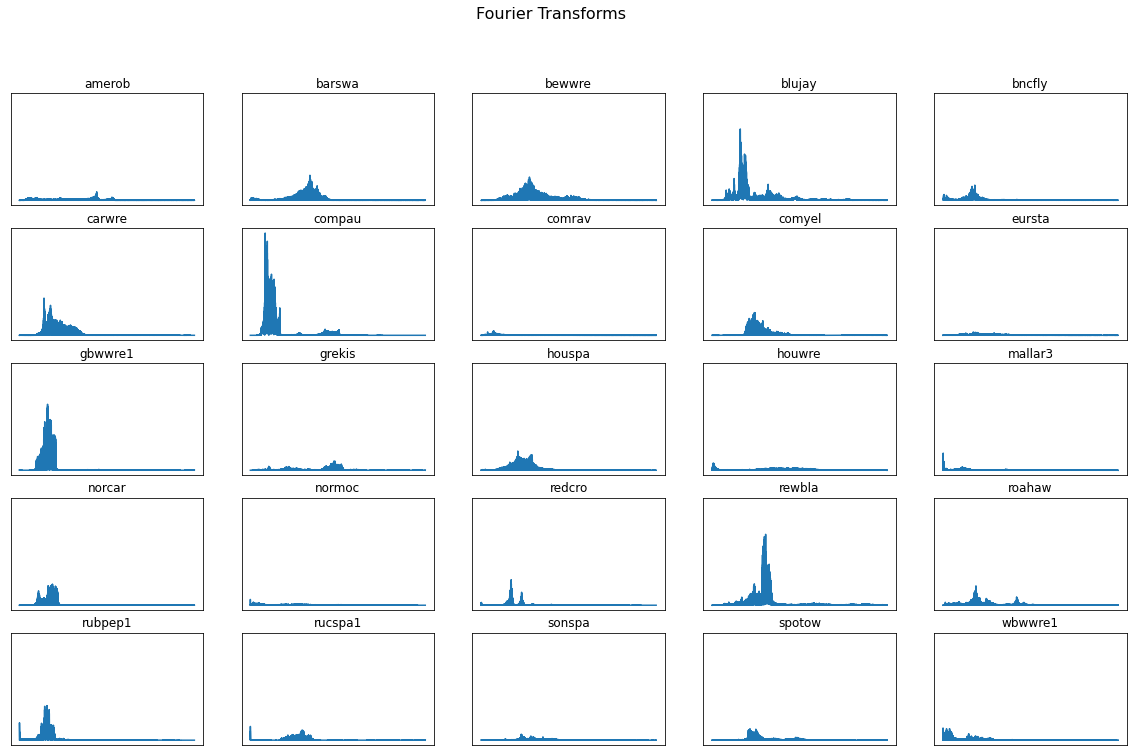

In [30]:
#fast fourier transformations on cleaned data
plot_fft(fft_new)

In [31]:
# Shuffle the training data and limit the number of audio files to MAX_AUDIO_FILES
RANDOM_SEED = 123
SAMPLE_RATE = 16000
SIGNAL_LENGTH = 5 # seconds
SPEC_SHAPE = (48, 128) # height x width
FMIN = 500
FMAX = 12500
MAX_AUDIO_FILES = 9000

TRAIN = shuffle(TRAIN, random_state=RANDOM_SEED)[:MAX_AUDIO_FILES]

## Extract Spectrograms

Source: [Stefan Kahl](https://www.kaggle.com/stefankahl/birdclef2021-model-training)

In [32]:
audio_dir = '../input/birdclef-2021/train_short_audio/'
output_dir = '../working/melspectrogram_dataset/'
samples = []
with tqdm(total=len(TRAIN)) as pbar:
    for idx, row in TRAIN.iterrows():
        pbar.update(1)
        
        if row.primary_label in most_represented_birds:
            audio_file_path = os.path.join(audio_dir, row.primary_label, row.filename)
            samples += get_spectrograms(audio_file_path, row.primary_label, output_dir)
            
TRAIN_SPECS = shuffle(samples, random_state=RANDOM_SEED)
print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS'.format(len(TRAIN_SPECS)))

100%|██████████| 8548/8548 [13:42<00:00, 10.40it/s]

SUCCESSFULLY EXTRACTED 48129 SPECTROGRAMS


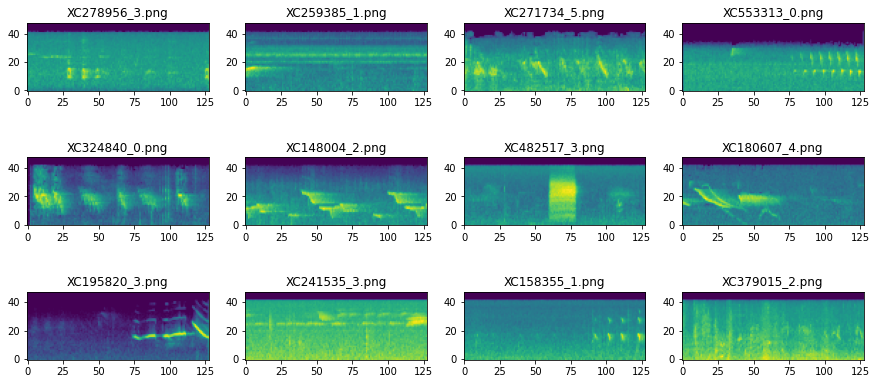

In [33]:
# Plot the first 12 log spectrograms of TRAIN_SPECS
plt.figure(figsize=(15, 7))
for i in range(12):
    spec = Image.open(TRAIN_SPECS[i])
    plt.subplot(3, 4, i + 1)
    plt.title(TRAIN_SPECS[i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

In [34]:
# Parse all samples and add spectrograms into train data, primary_labels into label data
specs, labels = [], []
with tqdm(total=len(TRAIN_SPECS)) as pbar:
    for path in TRAIN_SPECS:
        pbar.update(1)

        # Open image
        spec = Image.open(path)

        # Convert to numpy array
        spec = np.array(spec, dtype='float16')
        
        # Normalize between 0.0 and 1.0
        # and exclude samples with nan 
        spec -= spec.min()
        spec /= spec.max()
        if not spec.max() == 1.0 or not spec.min() == 0.0:
            continue

        # Add channel axis to 2D array
        spec = np.expand_dims(spec, -1)

        # Add new dimension for batch size
        spec = np.expand_dims(spec, 0)

        # Add to train data
        if len(specs) == 0:
            specs = spec
        else:
            specs = np.vstack((specs, spec))

        # Add to label data
        target = np.zeros((len(LABELS)), dtype='float16')
        bird = path.split(os.sep)[-2]
        target[LABELS.index(bird)] = 1.0
        if len(labels) == 0:
            labels = target
        else:
            labels = np.vstack((labels, target))

100%|██████████| 48129/48129 [1:22:28<00:00,  9.73it/s]


### Display Samples

Spectrograms of audio clips downsampled to 16kHz and reshaped to mono (1 channel).

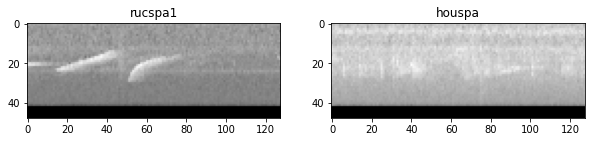

In [35]:
#display 2 classes as samples
for r in os.listdir("./melspectrogram_dataset/rucspa1/"):
    img_rucspa1 = load_img(("./melspectrogram_dataset/rucspa1/") + r)

for h in os.listdir("./melspectrogram_dataset/houspa/"):
    img_houspa = load_img("./melspectrogram_dataset/houspa/" + h)
    
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(img_rucspa1)
axs[0].set_title("rucspa1")
axs[1].imshow(img_houspa)
axs[1].set_title("houspa");

### Train-Test Split

In [36]:
train_specs, test_specs, train_labels, test_labels = train_test_split(specs, labels, test_size=0.2)

In [37]:
print(f"Train Spectrogram Shape:{train_specs.shape}")
print(f"Test Spectrogram Shape:{test_specs.shape}")
print('\n')
print(f"Train Labels Shape:{train_labels.shape}")
print(f"Test Labels Shape:{test_labels.shape}")

Train Spectrogram Shape:(38482, 48, 128, 1)
Test Spectrogram Shape:(9621, 48, 128, 1)


Train Labels Shape:(38482, 27)
Test Labels Shape:(9621, 27)


# Models

Several models will be used for comparison. The first is a baseline, followed by several different architectures inspired by others' projects.

### Baseline

The below model architecture was inspired by [Valerio Velardo's](https://github.com/musikalkemist/pytorchforaudio/blob/main/08%20Implementing%20a%20CNN%20network/cnn.py) baseline CNN in his YouTube series, [PyTorch for Audio](https://www.youtube.com/watch?v=gp2wZqDoJ1Y&list=PL-wATfeyAMNoirN4idjev6aRu8ISZYVWm&ab_channel=ValerioVelardo-TheSoundofAI).

In [38]:
EPOCHS = 50

In [39]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                  patience=2, 
                                                  verbose=1, 
                                                  factor=0.5),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              verbose=1,
                                              patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', 
                                                monitor='val_loss',
                                                verbose=0,
                                                save_best_only=True)]

In [40]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                 input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1))),
model.add(BatchNormalization()),
model.add(MaxPool2D(2, 2)),

model.add(Conv2D(32, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPool2D(2, 2)),

model.add(Conv2D(64, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPool2D(2, 2)),

model.add(Conv2D(128, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPool2D(2, 2)),

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(27, activation='relu'))
model.add(Activation('softmax'))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 128, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 128, 16)       64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 62, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 62, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 29, 64)         1

In [42]:
# Compile the model and specify optimizer, loss and metric
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

In [43]:
# Let's train the model for a few epochs
baseline_results = model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=EPOCHS)

Epoch 1/50
1203/1203 [==============================] - 16s 7ms/step - loss: 3.2202 - accuracy: 0.0890 - val_loss: 3.1309 - val_accuracy: 0.1325
Epoch 2/50
1203/1203 [==============================] - 8s 6ms/step - loss: 2.8460 - accuracy: 0.2253 - val_loss: 2.7150 - val_accuracy: 0.2647
Epoch 3/50
1203/1203 [==============================] - 8s 6ms/step - loss: 2.5682 - accuracy: 0.3071 - val_loss: 2.5010 - val_accuracy: 0.3394
Epoch 4/50
1203/1203 [==============================] - 8s 7ms/step - loss: 2.2669 - accuracy: 0.4076 - val_loss: 2.2798 - val_accuracy: 0.3962
Epoch 5/50
1203/1203 [==============================] - 8s 6ms/step - loss: 2.0401 - accuracy: 0.4675 - val_loss: 2.1952 - val_accuracy: 0.4283
Epoch 6/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.8637 - accuracy: 0.5133 - val_loss: 2.0923 - val_accuracy: 0.4577
Epoch 7/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.7011 - accuracy: 0.5588 - val_loss: 2.0363 - val_accuracy

In [44]:
train_scores = model.evaluate(train_specs, train_labels)
test_scores = model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

301/301 [==============================] - 1s 4ms/step - loss: 2.0190 - accuracy: 0.5256
Loss of the training model: 0.97
Training Accuracy: 76.49%


Loss of the testing model: 2.02
Test Accuracy: 52.56%


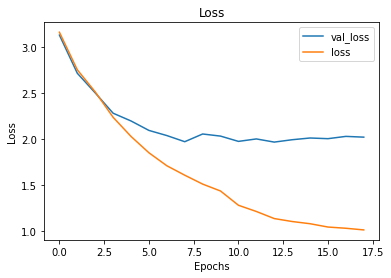

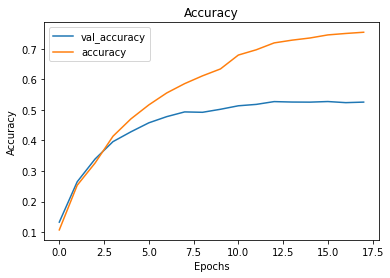

In [45]:
#baseline results
visualize_training_results(baseline_results)

### Stefan Kahl

In [46]:
tf.random.set_seed(RANDOM_SEED)

model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])

Source: [Stefan Kahl](https://www.kaggle.com/stefankahl/birdclef2021-model-training)

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 126, 16)       160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 46, 126, 16)       64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 63, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 61, 32)        4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 61, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 28, 64)        

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

In [49]:
model_2_results = model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=EPOCHS)

Epoch 1/50
1203/1203 [==============================] - 12s 9ms/step - loss: 3.0153 - accuracy: 0.1571 - val_loss: 2.5330 - val_accuracy: 0.3382
Epoch 2/50
1203/1203 [==============================] - 9s 7ms/step - loss: 2.2526 - accuracy: 0.3655 - val_loss: 1.9421 - val_accuracy: 0.4644
Epoch 3/50
1203/1203 [==============================] - 8s 6ms/step - loss: 1.9823 - accuracy: 0.4501 - val_loss: 1.8883 - val_accuracy: 0.4799
Epoch 4/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.8106 - accuracy: 0.5085 - val_loss: 1.7754 - val_accuracy: 0.5266
Epoch 5/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.6894 - accuracy: 0.5445 - val_loss: 1.6290 - val_accuracy: 0.5597
Epoch 6/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.6036 - accuracy: 0.5683 - val_loss: 1.6164 - val_accuracy: 0.5677
Epoch 7/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.5345 - accuracy: 0.5903 - val_loss: 1.7124 - val_accuracy

In [50]:
train_scores = model.evaluate(train_specs, train_labels)
test_scores = model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

301/301 [==============================] - 1s 3ms/step - loss: 1.3042 - accuracy: 0.6752
Loss of the training model: 0.64
Training Accuracy: 84.71%


Loss of the testing model: 1.30
Test Accuracy: 67.52%


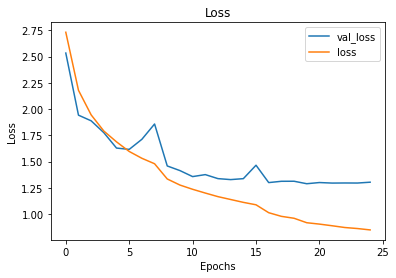

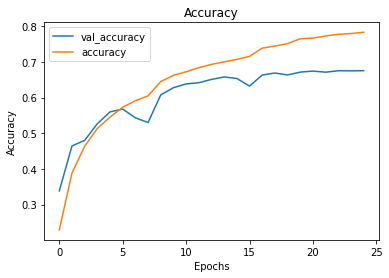

In [51]:
visualize_training_results(model_2_results)

## Seth Adams LSTM

In [52]:
N_CLASSES = 27

In [53]:
tf.random.set_seed(RANDOM_SEED)

lstm = Sequential()

lstm.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                 input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1))),
lstm.add(LayerNormalization(axis=2, name='layer_norm'))
lstm.add(TimeDistributed(layers.Reshape((-1,)), name='reshape'))
lstm.add(TimeDistributed(layers.Dense(64, activation='tanh'),
                        name='td_dense_tanh'))
lstm.add(Bidirectional(layers.LSTM(32, return_sequences=True)))
lstm.add(layers.Dense(64, activation='relu', name='dense_1_relu'))
lstm.add(MaxPool1D(name='max_pool_2d'))
lstm.add(Dense(32, activation='relu', name='dense_2_relu'))
lstm.add(Flatten(name='flatten'))
lstm.add(layers.Dropout(rate=0.5, name='dropout'))
lstm.add(Dense(32, activation='relu',
                     activity_regularizer=l2(0.001),
                     name='dense_3_relu'))
lstm.add(Dense(N_CLASSES, activation='softmax', name='softmax'))

Source: [Seth Adams](https://github.com/seth814/Audio-Classification/blob/master/models.py)

In [54]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 128, 16)       160       
_________________________________________________________________
layer_norm (LayerNormalizati (None, 48, 128, 16)       256       
_________________________________________________________________
reshape (TimeDistributed)    (None, 48, 2048)          0         
_________________________________________________________________
td_dense_tanh (TimeDistribut (None, 48, 64)            131136    
_________________________________________________________________
bidirectional (Bidirectional (None, 48, 64)            24832     
_________________________________________________________________
dense_1_relu (Dense)         (None, 48, 64)            4160      
_________________________________________________________________
max_pool_2d (MaxPooling1D)   (None, 24, 64)           

In [55]:
lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
lstm_results = lstm.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=EPOCHS)

Epoch 1/50
1203/1203 [==============================] - 21s 15ms/step - loss: 3.1233 - accuracy: 0.1067 - val_loss: 2.5337 - val_accuracy: 0.2878
Epoch 2/50
1203/1203 [==============================] - 17s 14ms/step - loss: 2.5295 - accuracy: 0.2813 - val_loss: 2.3730 - val_accuracy: 0.3320
Epoch 3/50
1203/1203 [==============================] - 17s 14ms/step - loss: 2.3353 - accuracy: 0.3326 - val_loss: 2.2582 - val_accuracy: 0.3644
Epoch 4/50
1203/1203 [==============================] - 17s 14ms/step - loss: 2.2269 - accuracy: 0.3649 - val_loss: 2.2203 - val_accuracy: 0.3721
Epoch 5/50
1203/1203 [==============================] - 17s 14ms/step - loss: 2.1223 - accuracy: 0.3940 - val_loss: 2.1353 - val_accuracy: 0.4022
Epoch 6/50
1203/1203 [==============================] - 17s 14ms/step - loss: 2.0388 - accuracy: 0.4199 - val_loss: 2.1077 - val_accuracy: 0.4120
Epoch 7/50
1203/1203 [==============================] - 17s 14ms/step - loss: 1.9727 - accuracy: 0.4385 - val_loss: 2.0900 -

In [57]:
train_scores = lstm.evaluate(train_specs, train_labels)
test_scores = lstm.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

301/301 [==============================] - 2s 6ms/step - loss: 2.1499 - accuracy: 0.4305
Loss of the training model: 1.14
Training Accuracy: 68.90%


Loss of the testing model: 2.15
Test Accuracy: 43.05%


### DrCapa

In [62]:
model = Sequential()
model.add(Conv1D(64, input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1), kernel_size=5, strides=4, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(4)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(N_CLASSES, activation='sigmoid'))

model.compile(optimizer = Adam(lr=2e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 31, 64)        384       
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 31, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 7, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 5, 64)         12352     
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 5, 64)         256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

In [64]:
capa_results = model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=EPOCHS)

Epoch 1/50
1203/1203 [==============================] - 9s 7ms/step - loss: 2.9709 - accuracy: 0.1889 - val_loss: 2.5246 - val_accuracy: 0.2839
Epoch 2/50
1203/1203 [==============================] - 7s 6ms/step - loss: 2.2824 - accuracy: 0.3412 - val_loss: 2.5936 - val_accuracy: 0.2953
Epoch 3/50
1203/1203 [==============================] - 7s 6ms/step - loss: 2.0658 - accuracy: 0.3967 - val_loss: 2.7369 - val_accuracy: 0.3061

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
Epoch 4/50
1203/1203 [==============================] - 7s 6ms/step - loss: 1.8383 - accuracy: 0.4667 - val_loss: 2.0978 - val_accuracy: 0.4006
Epoch 5/50
1203/1203 [==============================] - 8s 6ms/step - loss: 1.7122 - accuracy: 0.5044 - val_loss: 2.3740 - val_accuracy: 0.3684
Epoch 6/50
1203/1203 [==============================] - 8s 6ms/step - loss: 1.6200 - accuracy: 0.5265 - val_loss: 2.3124 - val_accuracy: 0.3933

Epoch 00006: ReduceLROnPlateau reducing learning rate 

In [65]:
train_scores = model.evaluate(train_specs, train_labels)
test_scores = model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

301/301 [==============================] - 1s 3ms/step - loss: 1.9979 - accuracy: 0.4741
Loss of the training model: 1.05
Training Accuracy: 69.99%


Loss of the testing model: 2.00
Test Accuracy: 47.41%


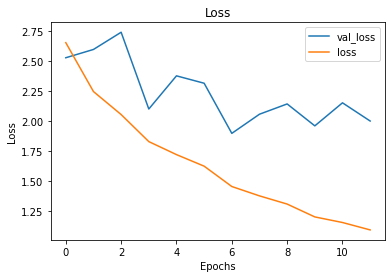

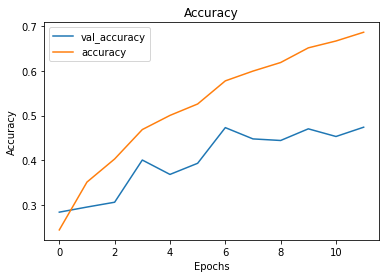

In [66]:
visualize_training_results(capa_results)

## Model Selection

The architecture that's been selected for further improvement is - [Stefan Kahl's](https://www.kaggle.com/stefankahl/birdclef2021-model-training) model. Despite its tendency to overfit, this is based on its higher training and testing accuracies. This decision also accounted for its ability to continue performance improvements along more epochs before early stopping.

The first thing to try will be adding L1 layer regularization in the input layer.

### L1 Regularization

In [67]:
tf.random.set_seed(RANDOM_SEED)

l1_model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), kernel_regularizer=l1(0.0005), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])

In [68]:
l1_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

In [69]:
l1_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 46, 126, 16)       160       
_________________________________________________________________
batch_normalization_10 (Batc (None, 46, 126, 16)       64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 63, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 61, 32)        4640      
_________________________________________________________________
batch_normalization_11 (Batc (None, 21, 61, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 30, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 28, 64)        

In [70]:
l1_results = l1_model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=EPOCHS)

Epoch 1/50
1203/1203 [==============================] - 10s 8ms/step - loss: 3.0247 - accuracy: 0.1566 - val_loss: 2.6556 - val_accuracy: 0.2549
Epoch 2/50
1203/1203 [==============================] - 8s 7ms/step - loss: 2.2630 - accuracy: 0.3673 - val_loss: 1.9673 - val_accuracy: 0.4586
Epoch 3/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.9906 - accuracy: 0.4509 - val_loss: 2.2535 - val_accuracy: 0.4058
Epoch 4/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.8170 - accuracy: 0.5100 - val_loss: 1.7892 - val_accuracy: 0.5267
Epoch 5/50
1203/1203 [==============================] - 9s 7ms/step - loss: 1.6935 - accuracy: 0.5448 - val_loss: 2.1199 - val_accuracy: 0.4502
Epoch 6/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.6206 - accuracy: 0.5648 - val_loss: 1.6535 - val_accuracy: 0.5603
Epoch 7/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.5443 - accuracy: 0.5903 - val_loss: 1.6243 - val_accuracy

In [71]:
train_scores = l1_model.evaluate(train_specs, train_labels)
test_scores = l1_model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

301/301 [==============================] - 1s 3ms/step - loss: 1.2779 - accuracy: 0.6850
Loss of the training model: 0.63
Training Accuracy: 85.06%


Loss of the testing model: 1.28
Test Accuracy: 68.50%


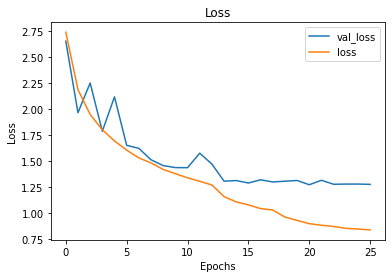

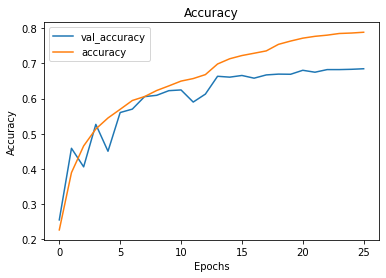

In [72]:
visualize_training_results(l1_results)

### L2 Regularization

In [73]:
tf.random.set_seed(RANDOM_SEED)

l2_model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), kernel_regularizer=l2(0.0005), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])

In [74]:
l2_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

In [75]:
l2_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 46, 126, 16)       160       
_________________________________________________________________
batch_normalization_14 (Batc (None, 46, 126, 16)       64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 23, 63, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 21, 61, 32)        4640      
_________________________________________________________________
batch_normalization_15 (Batc (None, 21, 61, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 10, 30, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 28, 64)        

In [76]:
l2_results = l2_model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=EPOCHS)

Epoch 1/50
1203/1203 [==============================] - 10s 7ms/step - loss: 3.0180 - accuracy: 0.1557 - val_loss: 2.3872 - val_accuracy: 0.3322
Epoch 2/50
1203/1203 [==============================] - 9s 7ms/step - loss: 2.2521 - accuracy: 0.3674 - val_loss: 2.0113 - val_accuracy: 0.4491
Epoch 3/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.9975 - accuracy: 0.4410 - val_loss: 1.8795 - val_accuracy: 0.4835
Epoch 4/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.8275 - accuracy: 0.4991 - val_loss: 1.8453 - val_accuracy: 0.4927
Epoch 5/50
1203/1203 [==============================] - 8s 6ms/step - loss: 1.7188 - accuracy: 0.5336 - val_loss: 1.7905 - val_accuracy: 0.5210
Epoch 6/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.6305 - accuracy: 0.5630 - val_loss: 1.7264 - val_accuracy: 0.5281
Epoch 7/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.5477 - accuracy: 0.5802 - val_loss: 1.4633 - val_accuracy

In [77]:
train_scores = l2_model.evaluate(train_specs, train_labels)
test_scores = l2_model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

301/301 [==============================] - 1s 3ms/step - loss: 1.2775 - accuracy: 0.6760
Loss of the training model: 0.73
Training Accuracy: 82.34%


Loss of the testing model: 1.28
Test Accuracy: 67.60%


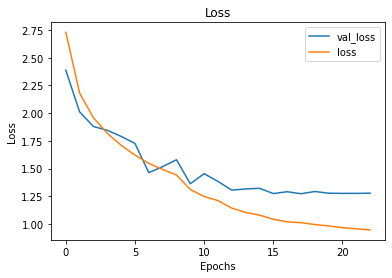

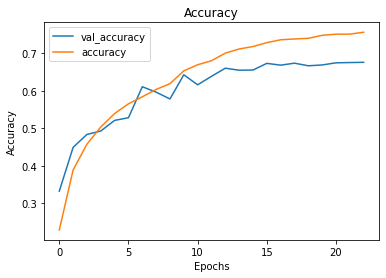

In [78]:
visualize_training_results(l2_results)

### Further Tunings

I am going to tune the L1 hyperparameter. I want to address any noise in the audio recordings and emphasize the characteristics of the bird vocalizations. I will also remove one of the dense layers and its adjacent dropout layer to reduce the amount of parameters the model has to learn.

In [79]:
tf.random.set_seed(RANDOM_SEED)

tuned_model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), kernel_regularizer=l1(0.005), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])

In [80]:
tuned_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

In [81]:
tuned_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 46, 126, 16)       160       
_________________________________________________________________
batch_normalization_18 (Batc (None, 46, 126, 16)       64        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 63, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 21, 61, 32)        4640      
_________________________________________________________________
batch_normalization_19 (Batc (None, 21, 61, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 10, 30, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 28, 64)        

In [82]:
tuned_results = tuned_model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=EPOCHS)

Epoch 1/50
1203/1203 [==============================] - 9s 7ms/step - loss: 2.8636 - accuracy: 0.2180 - val_loss: 2.0533 - val_accuracy: 0.4325
Epoch 2/50
1203/1203 [==============================] - 8s 6ms/step - loss: 2.0069 - accuracy: 0.4541 - val_loss: 2.4303 - val_accuracy: 0.4163
Epoch 3/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.7655 - accuracy: 0.5204 - val_loss: 1.7469 - val_accuracy: 0.5342
Epoch 4/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.5969 - accuracy: 0.5723 - val_loss: 1.5430 - val_accuracy: 0.5916
Epoch 5/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.4931 - accuracy: 0.6010 - val_loss: 1.5506 - val_accuracy: 0.5836
Epoch 6/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.4284 - accuracy: 0.6184 - val_loss: 1.6176 - val_accuracy: 0.5730

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
1203/1203 [==============================] -

In [83]:
train_scores = tuned_model.evaluate(train_specs, train_labels)
test_scores = tuned_model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

301/301 [==============================] - 1s 3ms/step - loss: 1.3074 - accuracy: 0.6761
Loss of the training model: 0.58
Training Accuracy: 87.73%


Loss of the testing model: 1.31
Test Accuracy: 67.61%


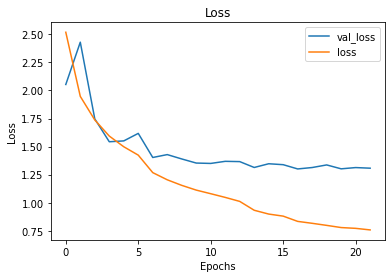

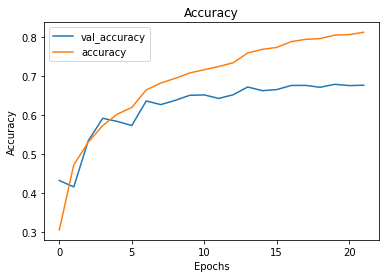

In [84]:
visualize_training_results(tuned_results)

### Add More Dropout Layers

In [85]:
tf.random.set_seed(RANDOM_SEED)

dropout_model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), kernel_regularizer=l1(0.005), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5), #<-- added dropout layer
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])

In [86]:
dropout_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

In [87]:
dropout_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 46, 126, 16)       160       
_________________________________________________________________
batch_normalization_22 (Batc (None, 46, 126, 16)       64        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 23, 63, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 21, 61, 32)        4640      
_________________________________________________________________
batch_normalization_23 (Batc (None, 21, 61, 32)        128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 10, 30, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 28, 64)        

In [88]:
dropout_results = dropout_model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=EPOCHS)

Epoch 1/50
1203/1203 [==============================] - 9s 7ms/step - loss: 3.0075 - accuracy: 0.1849 - val_loss: 2.2121 - val_accuracy: 0.4033
Epoch 2/50
1203/1203 [==============================] - 9s 7ms/step - loss: 2.2161 - accuracy: 0.3837 - val_loss: 2.0618 - val_accuracy: 0.4309
Epoch 3/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.9921 - accuracy: 0.4553 - val_loss: 1.8478 - val_accuracy: 0.4945
Epoch 4/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.8428 - accuracy: 0.5018 - val_loss: 3.5830 - val_accuracy: 0.2543
Epoch 5/50
1203/1203 [==============================] - 8s 6ms/step - loss: 1.7509 - accuracy: 0.5264 - val_loss: 1.6107 - val_accuracy: 0.5732
Epoch 6/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.6874 - accuracy: 0.5407 - val_loss: 1.7270 - val_accuracy: 0.5413
Epoch 7/50
1203/1203 [==============================] - 8s 7ms/step - loss: 1.6198 - accuracy: 0.5641 - val_loss: 1.9437 - val_accuracy:

In [89]:
train_scores = dropout_model.evaluate(train_specs, train_labels)
test_scores = dropout_model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

301/301 [==============================] - 1s 3ms/step - loss: 1.2177 - accuracy: 0.6870
Loss of the training model: 0.86
Training Accuracy: 79.07%


Loss of the testing model: 1.22
Test Accuracy: 68.70%


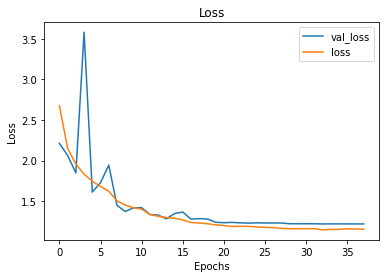

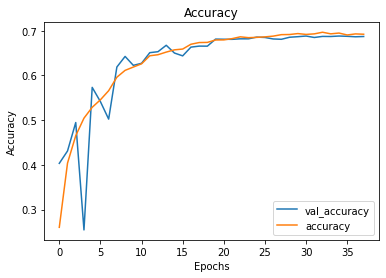

In [90]:
visualize_training_results(dropout_results)

### Less L1 Penalization

Going to try reducing the L1 alpha quantity to 0.001 and add another dropout layer to the third conv block. Will also increase the amount of epochs to 100.

In [91]:
tf.random.set_seed(RANDOM_SEED)

final_model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), kernel_regularizer=l1(0.001), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Dropout(0.5), #<-- newest dropout layer
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])

In [92]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

In [93]:
final_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 46, 126, 16)       160       
_________________________________________________________________
batch_normalization_26 (Batc (None, 46, 126, 16)       64        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 63, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 21, 61, 32)        4640      
_________________________________________________________________
batch_normalization_27 (Batc (None, 21, 61, 32)        128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 10, 30, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 28, 64)        

In [94]:
final_results = final_model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=100)

Epoch 1/100
1203/1203 [==============================] - 9s 7ms/step - loss: 3.0710 - accuracy: 0.1482 - val_loss: 2.3004 - val_accuracy: 0.3528
Epoch 2/100
1203/1203 [==============================] - 8s 7ms/step - loss: 2.4125 - accuracy: 0.3157 - val_loss: 2.1705 - val_accuracy: 0.3896
Epoch 3/100
1203/1203 [==============================] - 9s 7ms/step - loss: 2.1839 - accuracy: 0.3810 - val_loss: 2.0073 - val_accuracy: 0.4735
Epoch 4/100
1203/1203 [==============================] - 8s 7ms/step - loss: 2.0462 - accuracy: 0.4242 - val_loss: 2.7986 - val_accuracy: 0.4108
Epoch 5/100
1203/1203 [==============================] - 8s 7ms/step - loss: 1.9483 - accuracy: 0.4570 - val_loss: 1.8195 - val_accuracy: 0.5168
Epoch 6/100
1203/1203 [==============================] - 8s 7ms/step - loss: 1.8971 - accuracy: 0.4714 - val_loss: 1.8185 - val_accuracy: 0.5094
Epoch 7/100
1203/1203 [==============================] - 9s 7ms/step - loss: 1.8433 - accuracy: 0.4900 - val_loss: 1.6899 - val_ac

In [95]:
train_scores = final_model.evaluate(train_specs, train_labels)
test_scores = final_model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

301/301 [==============================] - 1s 3ms/step - loss: 1.2867 - accuracy: 0.6606
Loss of the training model: 1.06
Training Accuracy: 71.51%


Loss of the testing model: 1.29
Test Accuracy: 66.06%


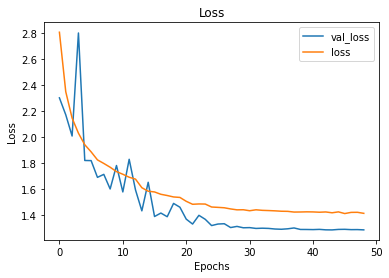

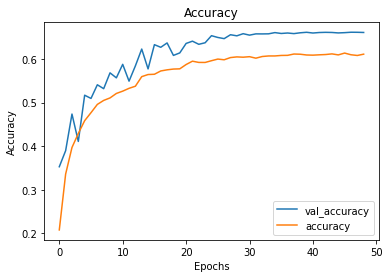

In [96]:
visualize_training_results(final_results)

## Results

Out of the models tested thus far, the model entitled `final_model` is one I would select as a prototype, based on its smaller tendency to overfit to the data.

## Future Work

The first iteration of this project sets the baseline for future work and improvements. More advanced steps in data pre-processing, especially with robust filtering methods, are warranted.

For BirdCLEF 2021, the main goal is to expand from the 27 species in this experiment to all species of birds in the dataset. This will incorporate more data for the models to train on and, hopefully, improve its performance.

Audio classification is highly generalizable to various domains. This task has been performed on [instrument classification](https://github.com/seth814/Audio-Classification). I hope to use this project as a springboard for music-related projects that need not relate to classification, such as sound synthesis and generation.

## References

- [Stefan Kahl](https://www.kaggle.com/stefankahl/birdclef2021-model-training)
- [Ayush Thakur](https://www.kaggle.com/ayuraj/birdclef-quick-eda-with-w-b)
- [DrCapa](https://www.kaggle.com/drcapa/birdclef-2021-starter)
- [Andrey Shtrauss](https://www.kaggle.com/shtrausslearning/keras-inference-birdclef2021-starter)
- [Valerio Velardo](https://github.com/musikalkemist/pytorchforaudio/blob/main/08%20Implementing%20a%20CNN%20network/cnn.py)
- [Francois Lemarchand](https://www.kaggle.com/frlemarchand/bird-song-classification-using-an-efficientnet)
- [Seth Adams](https://github.com/seth814/Audio-Classification/blob/master/models.py)
- [Adam Sabra](https://github.com/theadamsabra/InstrumentClassifier)